Using the SSD MobileNet v2 model retrained on Taco trash dataset

## Download the Taco dataset

Download 1000 images and their annotations.

In [2]:
img_path = "/home/tensorflow/waste/datasets/taco_dataset/test/"

In [30]:
label_path = "/home/tensorflow/waste/datasets/taco_dataset/label_map.pbtxt"

In [3]:
cd ../datasets/

/home/tensorflow/waste/datasets


mkdir taco_dataset

In [3]:
cd taco_dataset

/home/tensorflow/waste/datasets/taco_dataset


!wget https://github.com/pedropro/TACO/raw/master/data/annotations.json

Parse Taco annotations to generate a map<image_id> -> {"name", "bbox", "category_id", "width", "height"}

In [4]:
import json

In [5]:
taco_ann_raw = json.load(open('annotations.json', 'r'))

In [6]:
taco_ann_raw['images'][0]

{'id': 0,
 'width': 1537,
 'height': 2049,
 'file_name': 'batch_1/000006.jpg',
 'license': None,
 'flickr_url': 'https://farm66.staticflickr.com/65535/33978196618_e30a59e0a8_o.png',
 'coco_url': None,
 'date_captured': None,
 'flickr_640_url': 'https://farm66.staticflickr.com/65535/33978196618_632623b4fc_z.jpg'}

In [7]:
taco_ann_raw['annotations'][0].keys()

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])

In [8]:
image_annotations = {}
with open('image_links', 'w') as f:
  for img_ann in taco_ann_raw['annotations'][:min(1000, len(taco_ann_raw['annotations']))]:
    img_id = img_ann['image_id']
    img_bbox = img_ann['bbox']
    if img_id in image_annotations:
      image_annotations[img_id]['bboxes'].append(img_bbox)
    else:
      img_desc = taco_ann_raw['images'][img_id]
      img_link = img_desc['flickr_url']
      img_height = img_desc['height']
      img_width = img_desc['width']
      img_name = img_link.split('/')[-1]
      f.write(img_link+'\n')
      img_category = img_ann['category_id']
      image_annotations[img_id] = {"name":img_name, "bboxes":[img_bbox],
                                    "category_id":img_category,
                                    "width":img_width,
                                  "height":img_height}

Download the images

%%capture
!wget -i image_links

In [9]:
cd ../../work

/home/tensorflow/waste/work


In [10]:
pwd

'/home/tensorflow/waste/work'

## Setup

In [4]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)
%matplotlib inline

In [5]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [6]:
from object_detection.builders import model_builder
from object_detection.utils import config_util

## Processing functions

In [8]:
model_path = '/home/tensorflow/waste/models/trained/'

In [9]:
model_config_path = os.path.join(model_path, 'pipeline.config')

In [10]:
model_checkpoint = os.path.join(model_path, 'checkpoint')

In [11]:
configs = config_util.get_configs_from_pipeline_file(model_config_path)

In [12]:
model_config = configs['model']

In [13]:
detection_model = model_builder.build(model_config=model_config, is_training=False)

In [14]:
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)

In [15]:
ckpt.restore(os.path.join(model_checkpoint, 'ckpt-0')).expect_partial()

In [16]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    
    return detections, prediction_dict, tf.reshape(shapes, [-1])

In [18]:
from six import BytesIO
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [31]:
category_index = label_map_util.create_category_index_from_labelmap(label_path, use_display_name=True)

In [95]:
img = os.path.join(img_path+'UC84o9pUSRAbX0zHFozppxjWHGBGLmnC0ppwq15p.jpeg')

In [96]:
image_np = load_image_into_numpy_array(img)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

In [98]:
detections, predictions_dict, shapes = detect_fn(input_tensor)
start_time = time.perf_counter()
for _ in range(100):
    detections, predictions_dict, shapes = detect_fn(input_tensor)
end_time = time.perf_counter()
print(f"Avg inference time: {(end_time-start_time)/100} seconds")

Avg inference time: 0.06329813157999524 seconds


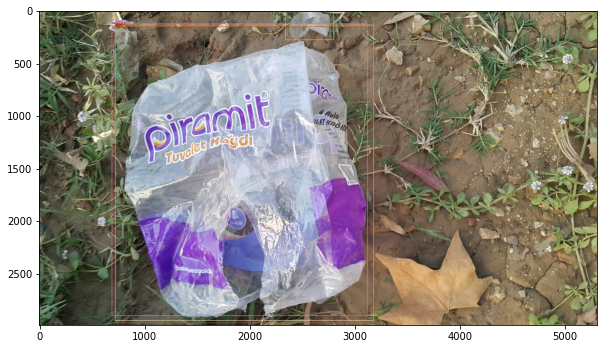

In [99]:
image_np_with_detections = image_np.copy()
vis_util.visualize_boxes_and_labels_on_image_array(
                  image_np_with_detections,
                  detections['detection_boxes'][0].numpy(),
                  (detections['detection_classes'][0].numpy() + 1).astype(int),
                  detections['detection_scores'][0].numpy(),
                  category_index,
                  use_normalized_coordinates=True,
                  max_boxes_to_draw=200,
                  min_score_thresh=.20,
                  line_thickness=5,
                  agnostic_mode=False)
              
plt.figure(figsize=(10, 10))
plt.imshow(image_np_with_detections)
plt.show()

In [24]:
def compute_iou(boxA, boxB):
  """
  Compute the Intersection over Union metric for the two bounding boxes.
  The boxes are provided in [xA, yA, xB, yB] format
  """
  # determine the (x, y)-coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou

In [25]:
def bbox_tf_to_normal(tf_bbox, img_width, img_height):
  """
  Convert a bbox from TensorFlow format (ymin, xmin, ymax, xmax),
  where the values are normalised, to (xmin, ymin, xmax, ymax)
  rescaled to the image size
  """
  return [tf_bbox[1]*img_width, tf_bbox[0]*img_height,
          tf_bbox[3]*img_width, tf_bbox[2]*img_height]

In [26]:
def bbox_taco_to_normal(taco_bbox):
  """
  Convert a bbox from Taco format (xmin, ymin, width, height)
  to normal format (xmin, ymin, xmax, ymax)
  """
  return [taco_bbox[0], taco_bbox[1],
          taco_bbox[0]+taco_bbox[2], taco_bbox[1]+taco_bbox[3]]

In [197]:
def bbox_taco_to_tf(taco_bbox, taco_annotation):
  """
  Convert a taco bbox to TF format

  Parameters
  ==========
  taco_annotation   -- dict("name", "bbox", "width", "height")
  """
  xmin, ymin, bbwidth, bbheight = taco_bbox
  width = taco_annotation['width']
  height = taco_annotation['height']
  return [ymin/height, xmin/width, (ymin+bbheight)/height, (xmin+bbwidth)/width]

In [236]:
def show_image(img_annotation, resize=None, with_bbox=True):
    image = Image.open(img_path+img_annotation['name'])
    if resize:
        image = image.resize(resize)
    npim = image2np(image)
    boxes = np.ndarray(shape=(len(img_annotation['bboxes']),4))
    if with_bbox:
        for idx,box in enumerate(img_annotation['bboxes']):
            boxes[idx] = bbox_taco_to_tf(box, img_annotation)
    vis_util.draw_bounding_boxes_on_image_array(npim,boxes)
    plt.figure(figsize=(12, 8))
    plt.imshow(npim)
    plt.show()

In [173]:
def tf_bbox_trim_zeros(tf_bbox):
    """Removes the zero bboxes"""
    fin = 0
    for box in tf_bbox[0]:
        if sum(box) == 0:
            break
        fin += 1
    return tf_bbox[:,:fin, :]